# Data Analysis of Mental Health in the Tech Industry

In [1]:
# COVID-19 KOREA DATA ANALYSIS
# ----------------------------------------------------------------------------------------------------------------


# INITIATION ------------

# System information
import os

# Data preparation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skimage as ski
import seaborn as sns

# Data transformation & algorithms
import numpy as np
import scipy as sp
import sqlite3 as sql

# Data modeling
import sklearn as sk

# Miscellaneous
import math
from tabulate import tabulate
from processes import \
    preparation, \
    transformation, \
    cleaning, \
    visualization, \
    modeling

print(
    'CURRENT DIRECTORY:\n'
    '. = \"', os.getcwd(), '\"', sep=''
)

for dirName, _, filenames in os.walk('.'):
    if dirName[2:3] != '.':
        print('\n', dirName, sep='')
        for filename in filenames:
            print(os.path.join(dirName, filename))


CURRENT DIRECTORY:
. = "G:\My Drive\Codes\.Projects\DS\Turing\2 Data Analysis\S1\Project"

.
.\215.ipynb
.\.gitignore
.\LICENSE
.\README.md
.\DataAnalysis_MentalHealth.ipynb
.\requirements.txt

.\processes
.\processes\preparation.py
.\processes\transformation.py
.\processes\visualization.py
.\processes\modeling.py
.\processes\cleaning.py

.\processes\__pycache__
.\processes\__pycache__\preparation.cpython-311.pyc
.\processes\__pycache__\transformation.cpython-311.pyc
.\processes\__pycache__\cleaning.cpython-311.pyc
.\processes\__pycache__\visualization.cpython-311.pyc
.\processes\__pycache__\modeling.cpython-311.pyc

.\processes\tools
.\processes\tools\modify_cls.py

.\processes\tools\__pycache__
.\processes\tools\__pycache__\modify_cls.cpython-311.pyc

.\data
.\data\mental_health.sqlite


## Familiarization with the Data

I will use the pandas library to load the data into a DataFrame and explore its shape, columns, and summary
statistics. This will help us identify any potential issues with the data quality, such as missing values, outliers, or incorrect formats. We will also visualize some key variables using matplotlib and seaborn to gain insights into the distribution and relationships of the data.


In [2]:
# EXECUTION -------------

# Display plots directly in the notebook interface
%matplotlib inline

# Connect to database
con = sql.connect('./data/mental_health.sqlite')

# Convert Answer into dataframe
Answer = pd.read_sql('SELECT * FROM Answer', con)

# First 10 observations
Answer.head(10)


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
5,33,2014,6,1
6,35,2014,7,1
7,39,2014,8,1
8,42,2014,9,1
9,23,2014,10,1


In [3]:
# Convert Question into dataframe
Question = pd.read_sql('SELECT * FROM Question', con)

# First 10 observations
Question.head(10)


,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
5,Do you have a family history of mental illness?,6
6,Have you ever sought treatment for a mental he...,7
7,How many employees does your company or organi...,8
8,Is your employer primarily a tech company/orga...,9
9,Does your employer provide mental health benef...,10


In [4]:
# Convert dataset into dataframe
Survey = pd.read_sql('SELECT * FROM Survey', con)

# First observations
Survey


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


### Improving Readability
One of the steps in data analysis is to improve the readability and format of the dataset.

For the numerical data, I will assign the 'date & time' columns with `datetime` data type for further effective data
manipulation.
Furthermore, for the categorical data, I will standardize several of these columns when they can be
considered to be (at least) ordinal variables.

By improving the readability and format of the dataset, we can enhance the quality and clarity of the data analysis. We can also save time and space when performing operations on the data.


In [5]:
# Improve Dataset's Readability & Reformat Numerical & Categorical Data
Survey['Description'] = 'Mental Health Survey for ' + Survey['SurveyID'].astype(str).str[:]
Question.rename(columns={'questiontext': 'QuestionText', 'questionid': 'QuestionID'}, inplace=True)


print('# Categorical data are simplified and reformatted')
print('# Numerical values for appropriate levels are assigned.')


# Categorical data are simplified and reformatted
# Numerical values for appropriate levels are assigned.


In [6]:
Answer.update_cols()
Answer.recap()


Number of Observations: 236898; 
Number of Features: 4.
- Categorical features: AnswerText; 
- Numerical features: SurveyID, UserID, QuestionID.


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
5,33,2014,6,1
6,35,2014,7,1
7,39,2014,8,1
8,42,2014,9,1
9,23,2014,10,1


## Data Cleaning
Before analyzing the Coursera dataset, some data cleaning steps will be performed to ensure the quality and validity of the data. In this section, we will describe the data cleaning process that we applied to the data.



First, any observations with erroneous values that are in unsuitable formats or missing values will be handled.

In [7]:
# HANDLING ERRONEOUS VALUES

# Cleaning the dataset
if Answer.has_nan() or Answer.has_na():
    ## Observations with erroneous non-numeric data such as Title, Organization, Certificate Type, and Difficulty are
    # removed;
    Answer.dropna(subset=''.split(', '), inplace=True)
    ## Due to limited number of observations, invalid numeric data are replaced with the variables' medians
    Answer.fillna(Answer.median(numeric_only=True, skipna=True), inplace=True)

if Question.has_nan() or Question.has_na():
    ## Observations with erroneous non-numeric data such as Title, Organization, Certificate Type, and Difficulty are
    # removed;
    Question.dropna(subset=''.split(', '), inplace=True)
    ## Due to limited number of observations, invalid numeric data are replaced with the variables' medians
    Question.fillna(value=Question['questionid'], inplace=True)

print('\n# All datasets no longer contain unrepresentable or missing data.')


Invalid values not found.
Missing values not found.
Invalid values not found.
Missing values not found.

# All datasets no longer contain unrepresentable or missing data.


Second, any duplicate samples and features based on IDs and names will be investigated further from the dataset to understand the reasons behind these duplicates and to avoid redundancy and bias.

In [8]:
# REMOVING DUPLICATE SAMPLES & FEATURES

# Remove duplicated IDs
ifDup_a = Answer.has_duplicates('index', rm=True)
ifDup_q = Question.has_duplicates('index', rm=True)


Duplicated IDs not found.
Duplicated IDs not found.


Third, any outliers in the numeric variables will be treated by observing boxplots and calculating the interquartile
range (IQR) for each variable. Any values that are more than 1.5 times the IQR above or below the first or third
quartile will be considered potential outliers which will require further careful treatment.

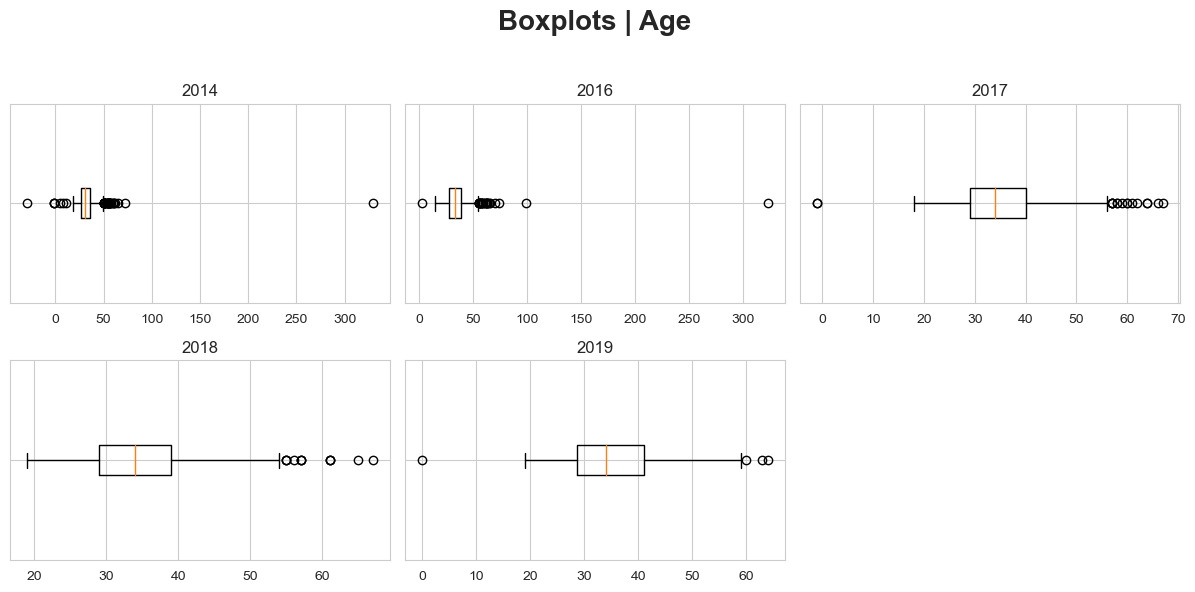

In [28]:
# TREATING OUTLIERS - AGE
con.execute(
    """
    -- Remove old Age dataset
    DROP TABLE IF EXISTS Age;
    """
)

con.execute(
    """
    -- Create Age dataset
    CREATE TABLE Age (
        UserID INTEGER,
        age INTEGER,
        SurveyID INTEGER
    )
    """
)

con.execute(
    """
    -- Insert values into Age
    INSERT INTO Age (UserID, age, SurveyID)
    SELECT UserID, CAST(AnswerText AS INTEGER), SurveyID
    FROM Answer
    WHERE QuestionID = 1
    """
)


def boxplots_age(years, xlim=None):
    n_cols = math.ceil(math.sqrt(len(years)))
    n_rows = math.ceil(len(years)/n_cols)

    # Create a figure with subplots
    figure, axes = plt.subplots(
        ncols=n_cols,
        nrows=n_rows,
        dpi=100,
        figsize=(min(16, 4*n_cols), min(12, 3*n_rows))
    )

    axes = np.array(axes).flatten()

    # Fill subplots with boxplots
    for i, year in enumerate(years):
        data = pd.read_sql(
            """
            SELECT age
            FROM Age
            WHERE SurveyID = '%s'
            """ % year,
            con
        )

        axes[i].boxplot(data, vert=False)
        axes[i].set_title(f'{year}', fontsize=12)
        axes[i].set_yticklabels([])
        if xlim is not None:
            axes[i].set_xlim(xlim)
        axes[i].grid(visible=True)

    # Remove the last empty subplot, adjust layout and title
    for i in range(len(years), len(axes)):
        figure.delaxes(axes[i])

    figure.suptitle(
        'Boxplots | Age\n',
        fontsize=20,
        fontweight='bold'
    )
    figure.subplots_adjust(hspace=0.2, wspace=0.2)
    figure.tight_layout()

    # Display the plot
    plt.show()


years = (2014, 2016, 2017, 2018, 2019)
boxplots_age(years)


In [10]:
# Inspect outliers for ages
## Loop through each column with outliers
for year in years:
    ### Compute IQR and select columns of interest
    data = Answer[(Answer['SurveyID'] == year) & (Answer['QuestionID'] == 1)].copy()
    data['AnswerText'] = pd.to_numeric(data['AnswerText'], errors='coerce')
    q1, q3 = data['AnswerText'].quantile((.25, .75))
    IQRange = q3 - q1
    cols = ['UserID','AnswerText']

    ### Select rows with values outside the IQR
    susValues = data[cols][(data['AnswerText'] < q1 - 1.5 * IQRange) | (data['AnswerText'] > q3 + 1.5 * IQRange)]

    ### Rearrange the 'outlier' rows based on data of interest
    susValues.sort_values('AnswerText', inplace=True, ascending=False)
    susValues.reset_index(drop=True, inplace=True)
    susValues.index += 1

    ### Display the outliers
    print(
        f"YEAR: {year}\n"
        f"{tabulate(susValues, tablefmt='simple')}\n"
        f"\n"
    )


YEAR: 2014
--  ----  ---
 1   365  329
 2  1183   72
 3   561   65
 4   521   62
 5   953   61
 6  1237   60
 7   298   60
 8   472   58
 9   476   57
10   644   57
11   467   57
12   632   56
13  1187   56
14   295   56
15   871   56
16   373   55
17   965   55
18   420   55
19   499   54
20   653   54
21   348   54
22   912   53
23   905   51
24  1160   51
25   528   51
26   857   51
27   896   51
28  1107   50
29   899   50
30   575   50
31   607   50
32   582   50
33    39   50
34  1091   11
35   990    8
36   735    5
37   716   -1
38  1128   -1
39   391   -1
40   144  -29
--  ----  ---


YEAR: 2016
--  ----  ---
 1  1825  323
 2  1633   99
 3  2378   74
 4  2482   70
 5  1962   66
 6  2146   65
 7  2006   63
 8  1569   63
 9  2161   63
10  2485   63
11  1852   62
12  1745   61
13  1780   61
14  1971   59
15  2133   59
16  1910   58
17  2387   57
18  1565   57
19  2428   57
20  1701   57
21  2586   56
22  1564   56
23  2327   56
24  2035   56
25  2690   56
26  1917    3
--  ----  

Any values of age that are below 15 and above 70 should be removed from the data.

In [11]:
con.execute(
    """
    -- Remove old Updated Answer dataset
    DROP TABLE IF EXISTS Answer_upd;
    """
)

con.execute(
    """
    -- Create Updated Answer dataset
    CREATE TABLE Answer_upd (
        AnswerText TEXT,
        SurveyID INTEGER,
        UserID INTEGER,
        QuestionID INTEGER
    )
    """
)

con.execute(
    """
    -- Insert values into Answer_upd
    INSERT INTO Answer_upd (AnswerText, SurveyID, UserID, QuestionID)
    SELECT *
    FROM Answer
    WHERE QuestionID = 1 AND
    (CAST(AnswerText AS INTEGER) > 15 AND CAST(AnswerText AS INTEGER) < 70)
    """
)


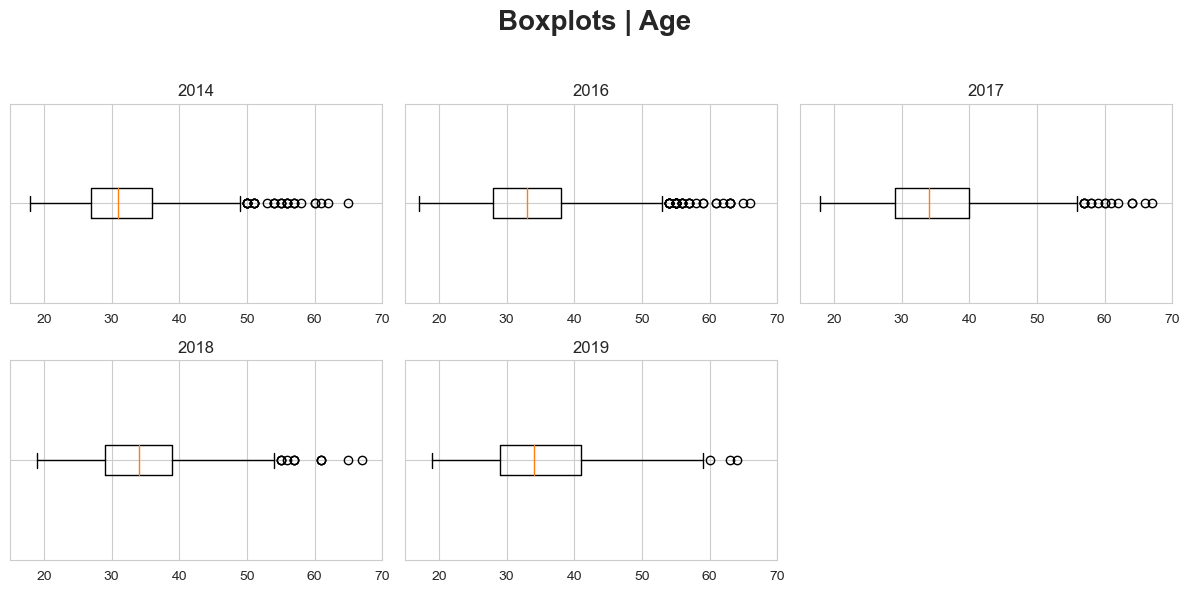

In [29]:
# Remove invalid ages from Age
con.execute(
    '''
    DELETE FROM Age
    WHERE age <= 15 OR age >= 70
    '''
)

# Show the updated boxplots after the removal
boxplots_age(years, xlim=(15, 70))


We will look into the distribution of ages more carefully using boxen plots (or letter-value plots).

A boxen plot is an enhanced version of the box plot that shows more details about the data distribution.
It uses a combination of box plots and kernel density estimation to display the distribution's shape more accurately, especially for large datasets or datasets with many outliers.

Therefore, they can reveal more information about the data's skewness, multi-modality, and tail behavior compared
to traditional box plots. As a result, they are more informative and provide a more detailed view of the data distribution, especially when the dataset has many data points or outliers. They can reveal subtle features of the data that might not be apparent in a standard box plot.

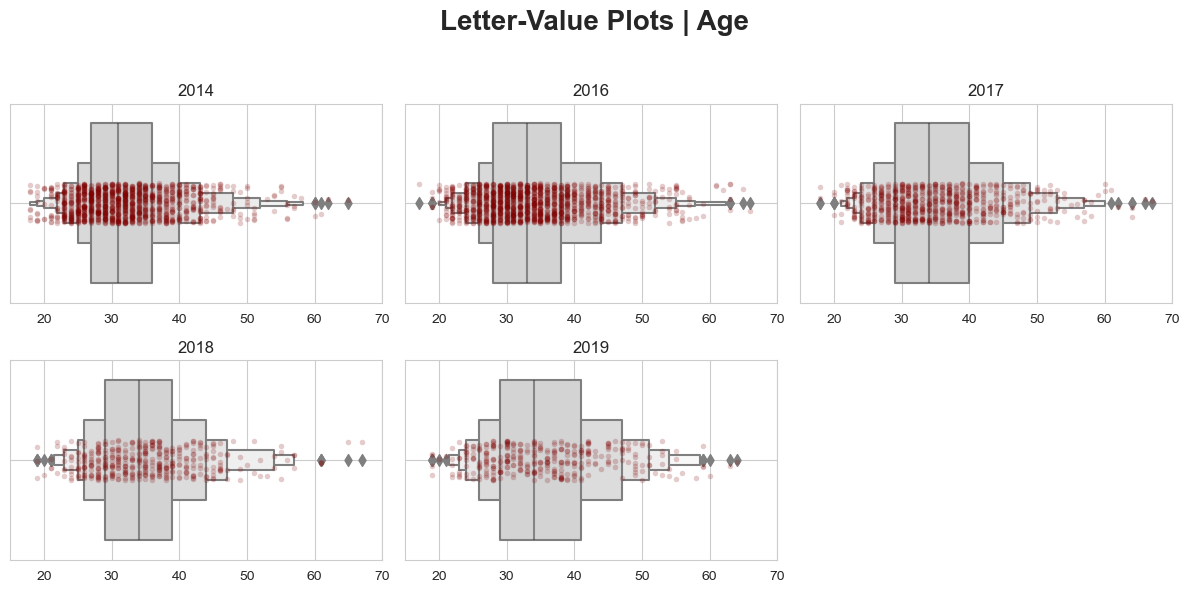

In [30]:
# Letter-value plots of quantitative data
n_cols = math.ceil(math.sqrt(len(years)))
n_rows = math.ceil(len(years)/n_cols)

# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=n_cols,
    nrows=n_rows,
    dpi=100,
    figsize=(min(16, 4*n_cols), min(12, 3*n_rows))
)

axes = np.array(axes).flatten()

# Fill subplots with boxenplots
for i, year in enumerate(years):
    data = pd.read_sql(
        """
        SELECT age
        FROM Age
        WHERE SurveyID = '%s'
        """ % year,
        con
    )

    sns.boxenplot(data['age'], ax=axes[i], color='lightgray', orient='h')
    sns.stripplot(data=data['age'], size=4, color='maroon', alpha=0.2, ax=axes[i], orient='h')
    axes[i].set_title(year, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_xlim(15, 70)
    axes[i].set_yticklabels([])
    axes[i].grid(visible=True)

# Remove the last empty subplot, adjust layout and title
for i in range(len(years), len(axes)):
    figure.delaxes(axes[i])

figure.suptitle(
    'Letter-Value Plots | Age\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


Now, we will inspect the possible values and the distribution of other answers.

In [35]:
def type_answers(i):
    answers = Answer['AnswerText'][Answer['QuestionID'] == i].unique()
    if sum(len(text) for text in answers)/len(answers) > 50:
        return '# Lengthy answers.'

    return answers

for i in Question['QuestionID'].unique()[1:]:
    print(
        f"{Question[Question['QuestionID'] == i].iloc[0, 0]}\n"
        f"---------------------------------------------------------------------------\n"
        f"{type_answers(i)}\n"
    )

What is your gender?
---------------------------------------------------------------------------
['Female' 'Male' 'Male-ish' 'Trans-female' 'something kinda male?'
 'queer/she/they' 'non-binary' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'queer' 'A little about you' 'p'
 'ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'fm' 'Transitioned, M2F'
 'Genderfluid (born female)' 'Other/Transfeminine'
 'Female or Multi-Gender Femme' 'Androgynous' 'male 9:1 female, roughly'
 '-1' 'Other' 'nb masculine' 'none of your business' 'genderqueer' 'Human'
 'Genderfluid' 'genderqueer woman' 'mtf' 'Queer' 'Fluid'
 'Male/genderqueer' 'Nonbinary' 'human' 'Unicorn' 'Male (trans, FtM)'
 'Genderflux demi-girl' 'female-bodied; no feelings about gender' 'AFAB'
 'Transgender woman' 'male' 'female' 'male/androgynous'
 'uhhhhhhhhh fem genderqueer?' 'God King of the Valaja

Regarding the gender data, we have decided to group the participants into 3 groups (Female, Male, and Mixed) for
several reasons, such as:
1. Data Consistency: By simplifying gender data into a limited set of categories, it ensures consistency and
standardization in the dataset.

2. Privacy and Ethics: Simplifying gender data can help in anonymizing the data and reducing the risk of reidentification.

3. Data Analysis: Aggregating gender data into a few categories allows for easier data analysis and comparison
between groups.

4. Sample Size: Combining these groups into a broader category, like "mixed," can help ensure statistical
significance when conducting analyses.

5. Overcoming Data Bias: This is a step towards addressing potential data bias and promoting inclusivity.

6. Interpretability: For communication and reporting purposes, simplifying gender data into a few categories makes
it easier for a broader audience to understand the findings and implications of the analysis.

## Exploratory Data Analysis



### Correlations
One of the data science techniques that we used in this project is correlation analysis. Correlation analysis is a statistical technique that measures the strength and direction of the relationship between two variables.


In [ ]:
# Heatmap that represents the correlation matrix of the numeric data
Time.corr_heatmap()


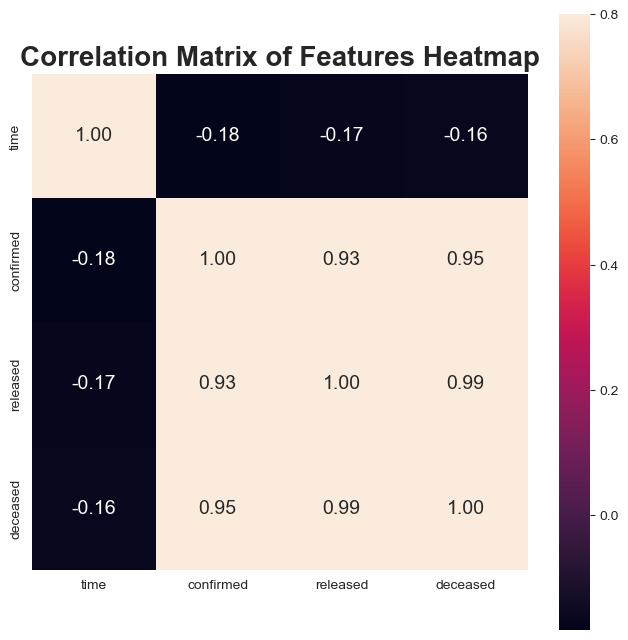

In [167]:
TimeProvince.corr_heatmap()

## Overview

<Figure size 1200x600 with 0 Axes>

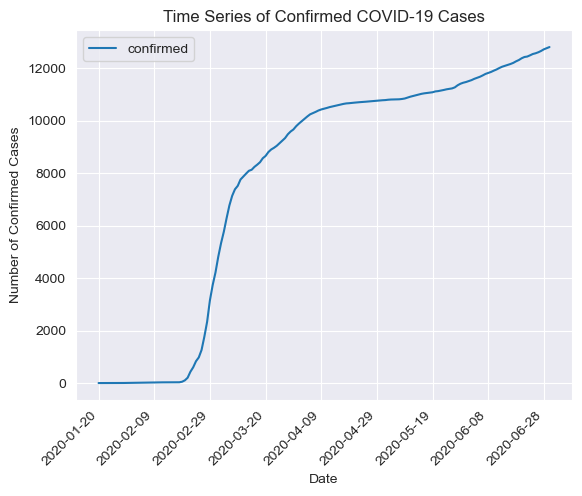

In [152]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the time series data
Time.plot('date', 'confirmed')

# Set the plot title and labels
plt.title('Time Series of Confirmed COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')

# Customize the x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the gridlines
plt.grid(True)

# Display the plot
plt.show()

## 1. How does the number of confirmed cases relate to different age groups?
Understanding the relationship between age groups and the number of confirmed cases can help in developing targeted strategies for different age demographics, such as prioritizing vaccination efforts. This can assist in protecting the most vulnerable age groups and reducing overall transmission rates.


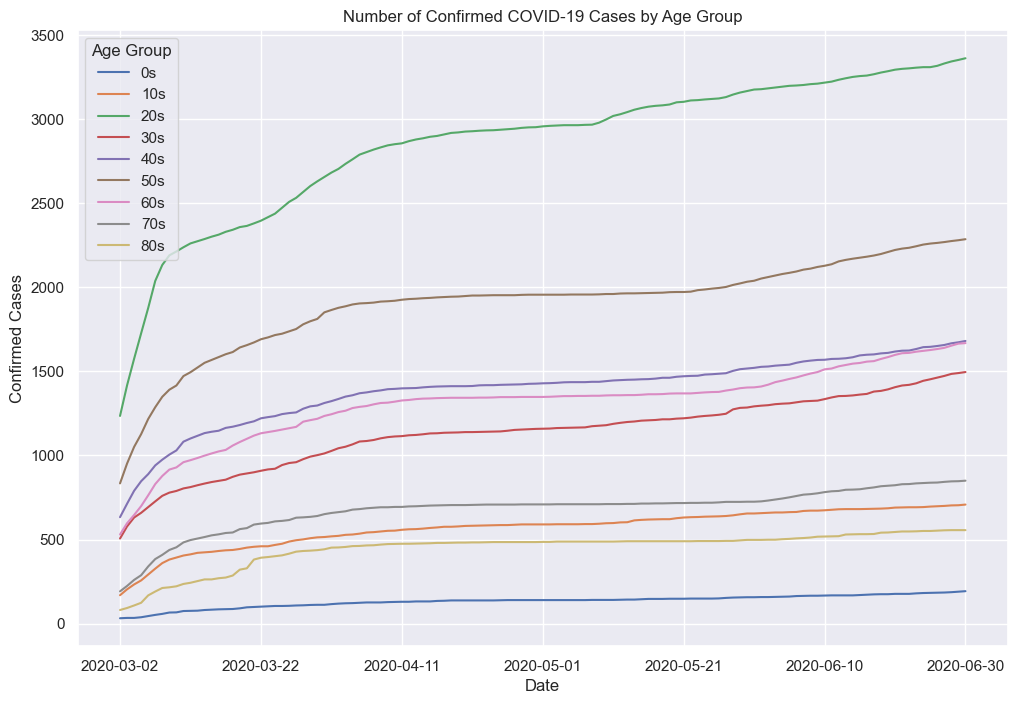

In [96]:
# Load the data
TimeAge = pd.read('./data/TimeAge.csv')

# Filter the relevant columns from TimeAge data
time_age_filtered = TimeAge[['date', 'age', 'confirmed']]

# Group the data by age and calculate the total confirmed cases for each age group on each date
grouped_data = time_age_filtered.groupby(['age', 'date']).sum().reset_index()

# Pivot the data to have age groups as columns and dates as rows
pivot_data = grouped_data.pivot(index='date', columns='age', values='confirmed')

# Plotting the data
pivot_data.plot(kind='line', figsize=(12, 8))
plt.title('Number of Confirmed COVID-19 Cases by Age Group')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(title='Age Group')
plt.show()


## 2. Are there any gender-based differences in the COVID-19 infection rate and recovery rate?
Analyzing gender-based differences in infection and recovery rates can provide insights into the susceptibility and immune response variations between genders. It can help in designing tailored prevention and treatment approaches, taking into account the specific needs and risks associated with each gender.


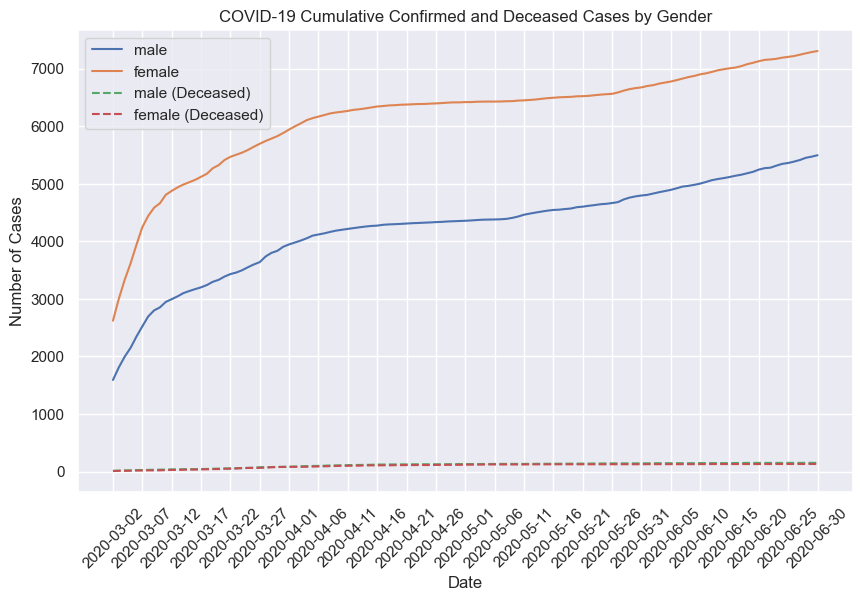

In [97]:
# Load the data
TimeGender = pd.read('./data/TimeGender.csv')

# Group the data by gender and calculate the cumulative sum
confirmed_by_gender = TimeGender.groupby('sex')['confirmed']
deceased_by_gender = TimeGender.groupby('sex')['deceased']

# Get unique genders
genders = TimeGender['sex'].unique()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the confirmed cases for each gender
for gender in genders:
    plt.plot(TimeGender[TimeGender['sex'] == gender]['date'], confirmed_by_gender.get_group(gender), label=gender)

# Plot the deceased cases for each gender
for gender in genders:
    plt.plot(TimeGender[TimeGender['sex'] == gender]['date'], deceased_by_gender.get_group(gender), linestyle='--', label=f'{gender} (Deceased)')

# Set the plot title and labels
plt.title('COVID-19 Cumulative Confirmed and Deceased Cases by Gender')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Get the current x-tick locations
xticks = plt.xticks()[0]

# Determine the desired number of x-ticks
desired_num_ticks = 24  # Adjust this value as per your requirement

# Calculate the step size for x-tick placement
step_size = int(len(xticks)/(desired_num_ticks - 1))

# Set the new x-tick locations
new_xticks = xticks[::step_size]
plt.xticks(new_xticks)

# Display the plot
plt.show()

## 3. What is the relationship between COVID-19 cases and geographical regions?
Identifying regional variations in COVID-19 cases can guide localized interventions and resource allocation to the areas with higher transmission rates. This allows for targeted public health measures, including testing, contact tracing, and healthcare provision, to effectively control the spread of the virus in specific regions.


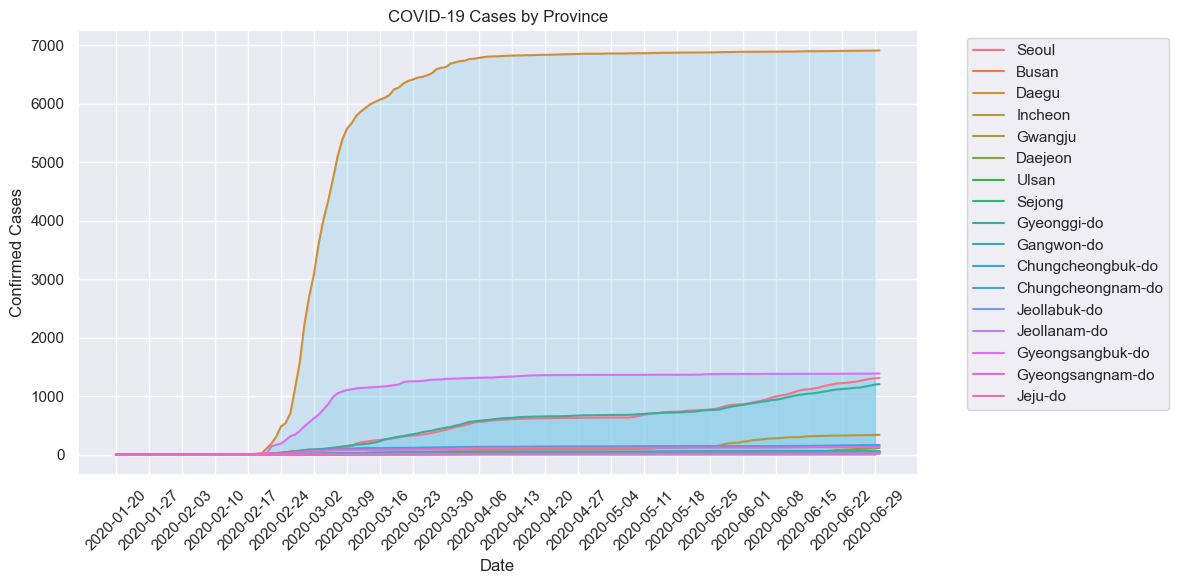

In [98]:
# Load the TimeProvince data
TimeProvince = pd.read_csv('./data/TimeProvince.csv')

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=TimeProvince, x='date', y='confirmed', hue='province')

# Fill the area below the line with color
for province in merged_data['province'].unique():
    province_data = merged_data[merged_data['province'] == province]
    plt.fill_between(province_data['date'], province_data['confirmed'], color='skyblue', alpha=0.3)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Cases by Province')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Get the current x-tick locations
xticks = plt.xticks()[0]

# Determine the desired number of x-ticks
desired_num_ticks = 24  # Adjust this value as per your requirement

# Calculate the step size for x-tick placement
step_size = int(len(xticks)/(desired_num_ticks - 1))

# Set the new x-tick locations
new_xticks = xticks[::step_size]
plt.xticks(new_xticks)

# Display the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4. How does the weather impact the spread and severity of COVID-19 cases?
Investigating the impact of weather on COVID-19 cases can aid in understanding environmental factors that contribute to the spread of the virus and guide public health measures. It can inform the development of weather-based predictive models and help authorities anticipate and respond to potential surges in cases during specific weather conditions.


In [68]:
TimeProvinceWeather = pd.merge(TimeProvince, Weather, how='left', on=['date', 'province'])
TimeProvinceWeather.head(1)

,date,time,province,confirmed,released,deceased,code,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,2020-01-20,16,Seoul,0,0,0,10000.0,0.7,-3.3,5.5,0.0,5.7,270.0,46.8


In [70]:
TimeProvinceWeather['date'] = pd.to_datetime(TimeProvinceWeather['date'], format='%Y-%m-%d')

### Entire South Korea

In [149]:
def plot_3d(d, title=''):
    # Create figure and axes
    fig = plt.figure(dpi=100, figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the variables
    ax.scatter3D(d['date'].values.astype(float), d['avg_temp'],
                 d['confirmed'])

    # Add error bars
    ax.errorbar(d['date'].values.astype(float), d['avg_temp'], d['confirmed'],
                yerr=d['min_temp'], zerr=d['max_temp'],
                fmt='none', ecolor='red')

    # Set plot's background color
    ax.set_facecolor('none')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Set plot's labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Average temperature')
    ax.set_zlabel('Confirmed cases')
    ax.set_title(title, fontsize=20, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Setting custom x-axis tick positions and labels
    ax.set_xticks([])

    # Show the plot
    plt.show()


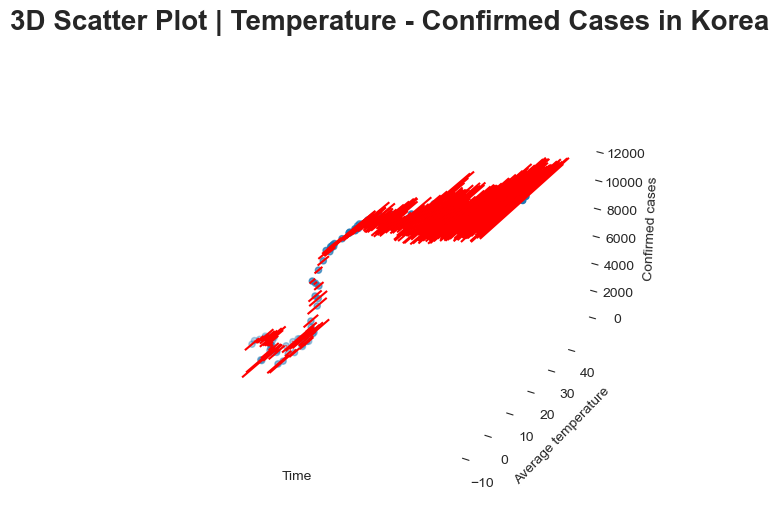

In [150]:
d = TimeProvinceWeather.groupby('date').agg({'confirmed': 'sum', 'avg_temp': 'mean',
                                             'min_temp': 'mean', 'max_temp': 'mean'})
d.reset_index(inplace=True)

plot_3d(d, title='3D Scatter Plot | Temperature - Confirmed Cases in Korea')


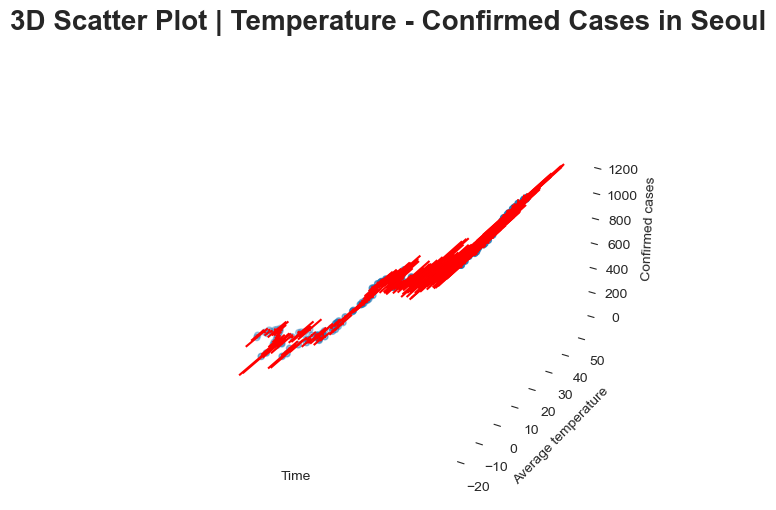

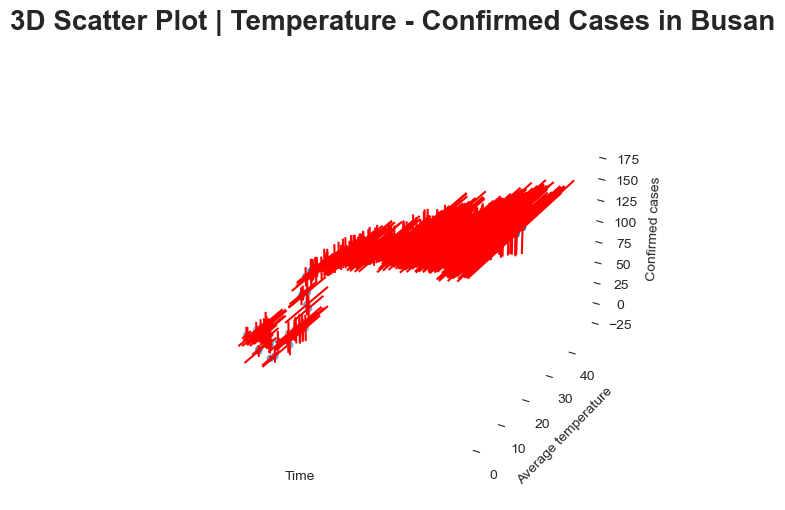

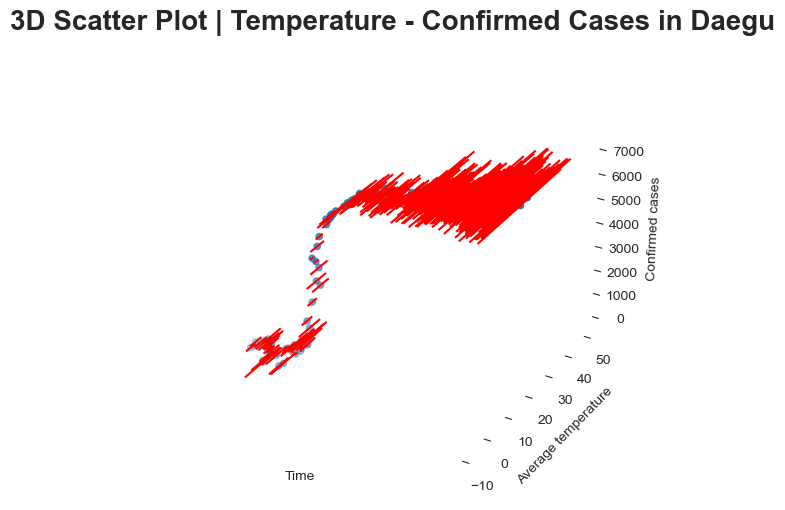

In [151]:
provinces = TimeProvinceWeather['province'].unique()

for p in provinces[:3]:
    d = TimeProvinceWeather[TimeProvinceWeather['province'] == p]
    plot_3d(d, title=f'3D Scatter Plot | Temperature - Confirmed Cases in {p}')

## Suggestions for Future Pandemic Prevention
Based on the analysis of the COVID-19 data in South Korea, several key insights and findings have emerged that can contribute to future pandemic prevention efforts. These suggestions are aimed at policymakers and healthcare professionals to enhance their preparedness and response strategies. The following recommendations are derived from the project's findings:

- Prioritize the care and protection of adults, considering their activity levels and potential vulnerability to infection.
- Pay special attention to the protection of females in Korea, as they may have specific risk factors or healthcare needs during a pandemic.
- Strengthen protective measures in highly-populated regions with high economic activities, as these areas may experience increased transmission risks due to population density and frequent interactions.
- Recognize the positive relationship between temperature and the severity and spread of COVID-19, and consider the impact of weather conditions in designing prevention strategies and resource allocation.
- Foster international collaboration and information sharing to improve global pandemic preparedness, response coordination, and the exchange of best practices.

It is important to note that these recommendations should be adapted and tailored to the specific context and circumstances of each country. Continuous monitoring, evaluation, and adaptation of strategies based on evolving scientific evidence and local conditions are essential for effective pandemic prevention and control.

By implementing these suggestions and incorporating the findings of this data science project, we can further strengthen our preparedness and response capabilities, mitigate the impact of future pandemics, and safeguard the health and well-being of populations worldwide.

